## Exercise Cifar100

In [1]:
# Check if gpu is used (optional)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12784287004666842680
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5536902221405132376
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2284836925445701821
physical_device_desc: "device: XLA_GPU device"
]


In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

import sklearn as sk
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D 
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation

2.3.1


In [3]:
# helper functions for visualisation
# plotting the loss functions used in this notebook
# we plot the loss we want to optimise on the left (in this case: accuracy)
def plot_history(history):
  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),'g-',
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),'r-',
           label = 'Validation accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(history.epoch, np.array(history.history['loss']),'g-',
           label='Train loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),'r-',
           label = 'Validation loss')
  plt.legend()

# Exercise overview

Since we have now definitely concluded that MNIST is too easy, we will move to a slightly more difficult data set to play with. It is called CIFAR100 (https://www.cs.toronto.edu/~kriz/cifar.html) and contains (still TINY) natural images of objects in 20 different classes, each with 5 sub-classes (100 classes in total).

To make the problem slightly easier, we will only use the coarse differentiation into 20 classes.

The code below shows a simple example of a convolutional neural network. Your first task is to try and understand the layers and their parameters, using the Keras documentation. Then start to play with it: try to change things and try to improve the result, using everything you have learnt thus far.


## Loading the data

In the code below, we load the data. The option 'coarse' selects the 20-class version (instead of the 100-class version).

In [4]:
# load train and test data
from tensorflow.keras.datasets import cifar100
(X_train_all, y_train_all_class), (X_test, y_test_class) = cifar100.load_data(label_mode='coarse')


169009152/169001437 [==============================] - 1482s 9us/step


In [5]:
# let's print the shape before we reshape and normalize
print("X_train_all shape", X_train_all.shape)
print("y_train_all shape", y_train_all_class.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test_class.shape)


X_train_all shape (50000, 32, 32, 3)
y_train_all shape (50000, 1)
X_test shape (10000, 32, 32, 3)
y_test shape (10000, 1)


### Data Preparation
* CIFAR dataset **requires some preparation** for use in a convnet

#### Reshaping the Image Data 
* **Convnets** require **NumPy array inputs** 
* Each **sample** must have the **shape**
> (**width**, **height**, **channels**)
* Each pixel has **three channels** (red, green, blue: 0-255), so sample shapes will be 
> **`(32, 32, 3)`**
* As the **neural network learns** from the images, it **creates many more channels**
    * These channels will **represent more complex features**, like **edges**, **curves** and **lines**
    * Enable network to **recognize digits** based on these features and how they’re **combined**  
  
* NumPy array method `reshape` receives a tuple representing the new shape

In [6]:
X_train_all = X_train_all.reshape((50000, 32, 32, 3))
print(X_train_all.shape)

X_test = X_test.reshape((10000, 32, 32, 3))
print(X_test.shape)

# some preprocessing ... convert integers to floating point and rescale them to [0,1] range
# normalized data leads to better models
X_train_all = X_train_all.astype('float32')
X_test = X_test.astype('float32')
X_train_all /= 255
X_test /= 255

# print the final input shape 
print("Train_all matrix shape", X_train_all.shape)
print("Test matrix shape", X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
Train_all matrix shape (50000, 32, 32, 3)
Test matrix shape (10000, 32, 32, 3)


In [7]:
# This data set contains a training set and a test set
# we still need to split off a validation set

# Number of test samples
N_test = X_test.shape[0]

# split off 10000 samples for validation
N_val = 6000
N_train = X_train_all.shape[0] - N_val

# now extract the samples into train, validate and test sets
# set random state = 0 to make sure you get the same split each time
X_train, X_val, y_train_class, y_val_class = train_test_split(X_train_all, y_train_all_class, test_size = N_val, random_state=0)


# let's take a subset of the training data first, for playing around
# Note that such a subset is only useful if it can guide your tuning process,
# i.e., if it leads you to similar decisions as you would make on the whole training set

X_train_small = X_train[:20000]
y_train_small_class = y_train_class[:20000]


print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')

X_train shape: (44000, 32, 32, 3)
44000 train samples
6000 validation samples


From the documentation of `train_test_split`:

>*test_size: float or int, default=None* 

>If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split. If int, represents the absolute number of test samples. If None, the value is set to the complement of the train size (which is also a parameter). If train_size is also None, it will be set to 0.25.

## Multi-class classification

For multi-class classification problems with k classes, we train one model output per class. Each of the k outputs represents the probability that the sample comes from that class. This means the target labels are vectors of k values, all of which are zero except for that which corresponds to the correct class.

There are multiple ways to achieve this. Here, we will convert class vectors to binary class matrices instead of 1 integer label, you now have 20 binary labels (1 for each class) these labels represent the desired class probabilities: all labels are zero, except the one for the right class, which is one.

This will result in a model that outputs vectors of 20 probabilities when calling its 'predict()' function. In the analysis notebook, we will obtain class labels by finding the largest probability.

In [8]:
# the labels from the downloaded data are integer numbers
# for a multi-class classification task, we again convert each integer
# to a vector with 19 zeros and a single '1', corresponding to the right class
num_classes = 20


y_train_all = keras.utils.to_categorical(y_train_all_class, num_classes)
y_train = keras.utils.to_categorical(y_train_class, num_classes)
y_val = keras.utils.to_categorical(y_val_class, num_classes)
y_test = keras.utils.to_categorical(y_test_class, num_classes)
y_train_small = keras.utils.to_categorical(y_train_small_class, num_classes)

# look at the new labels for the first sample
print(y_train[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


Note the shape of the training data. In the MNIST dataset, we had grayscale images, consisting of 28x28 pixels. As we were using Dense networks then, we flattened the pixels into a single vector per image, so the training data was a 2D tensor.

In the current assignment, the data consists of **colour** images, which means that each image consists of 3 arrays of pixels (RGB: red, green, blue). Every sample is now a tensor of 32x32x3 numbers. Since we will be using convolutional networks now, we leave these pixels in their original structure. 

It is a general agreement that the **first** dimension of the training data always reflects the number of samples and all other dimensions are the sample dimensions. Hence, our complete training set is a tensor of shape (44000, 32, 32, 3).

#### Labels 

labels = [
'aquatic mammals',
'fish',
'flowers',
'food containers',
'fruit and vegetables',
'household electrical devices',
'household furniture',
'insects',
'large carnivores',
'large man-made outdoor things',
'large natural outdoor scenes',
'large omnivores and herbivores',
'medium-sized mammals',
'non-insect invertebrates',
'people',
'reptiles',
'small mammals',
'trees',
'vehicles 1',
'vehicles 2'
]
  
The images are very low resolution, to the extent where it is often even hard for humans to recognise what is on them. Considering that there are less training samples than in the MNIST dataset, that there are twice as many classes and the data is more complex, it is clear that this task is a lot more difficult. Below are a few examples of the training data:

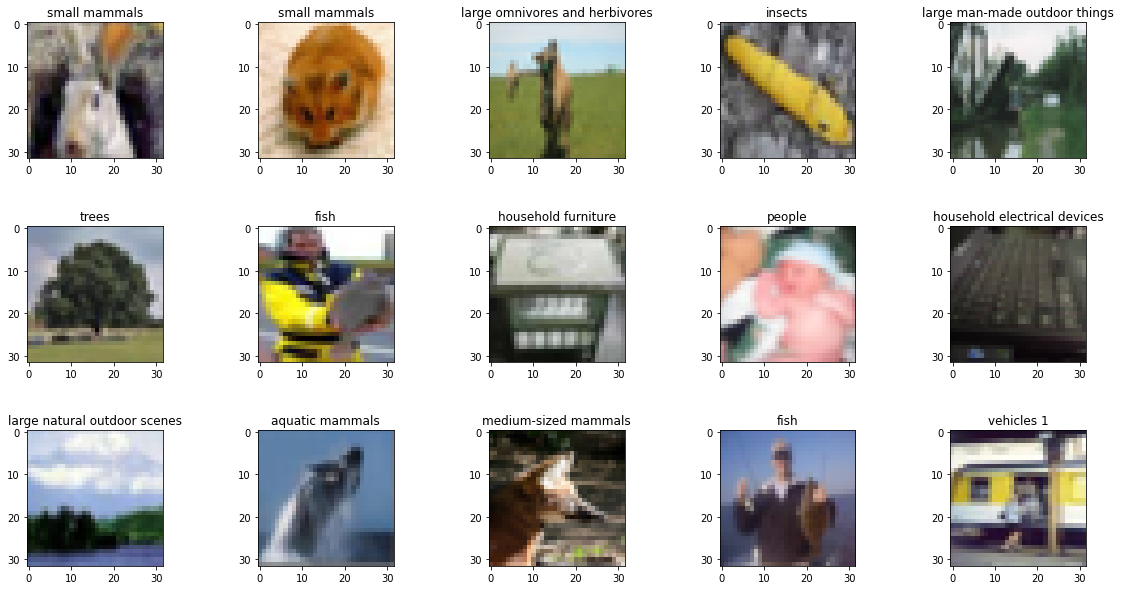

In [11]:
# Labels
labels = [
'aquatic mammals',
'fish',
'flowers',
'food containers',
'fruit and vegetables',
'household electrical devices',
'household furniture',
'insects',
'large carnivores',
'large man-made outdoor things',
'large natural outdoor scenes',
'large omnivores and herbivores',
'medium-sized mammals',
'non-insect invertebrates',
'people',
'reptiles',
'small mammals',
'trees',
'vehicles 1',
'vehicles 2'
]

f = plt.figure(figsize=(20,10))
for idx in range(15):
    plt.subplot(3,5,idx+1)
    plt.subplots_adjust(hspace=0.5)
    plt.title(labels[y_train_class[idx,0]])
    plt.imshow(X_train[idx],  interpolation='None')

# An initial model to show how it's done

The code below shows a simple example of a convolutional neural network.


In [12]:
'''Train a simple CNN on the CIFAR100 small images dataset.
Initial model based on example networks used for CIFAR10
e.g., https://keras.io/examples/cifar10_cnn/
'''

# The first conv layers have 32 filters (channels) with filter size 3x3
# note that this has no relation with the image size, which just happens to be 32x32 pixels!

def initial_model():
  model = Sequential()

  # Convolutional layers
  model.add(Conv2D(32, (3, 3), padding='same',input_shape=X_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  # end of convolutional layers, start of 'hidden' dense layers (can be more than 1 if necessary)
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))

  # Final dense layer = linear classifier
  #model.add(Dropout(0.1))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  opt = tf.keras.optimizers.Adam() #using defaults for now

  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

  return model



Some information about the model code:

- Just like for the Dense network, the input shape must be specified in the first layer. Where this was only a single number (the number of features) previously, it is now the dimension of a single training sample, so (32,32,3). The Conv2D layer expects a stack of 2D arrays as input. The first two dimensions of the input shape are the dimensions of these arrays, the third dimension is the number of 'channels' (see theory).
- Padding (same) is used here for all conv layers. This is quite standard and avoids you having to keep track of channel shapes (input and output channels of conv layers are equal if padding is used).
- As pooling reduces the size of each channel, it is common to increase the number of filters throughout the layers. This way spatial features (things you see on the image) are gradually translated into abstract features (concepts that are useful to make the classification).
- The code also shows a common practice of combining a few conv layers with the same dimensions before pooling. Note that this is not necessary, it's just how it is often done.
- If you use batchnorm, it is generally advised to put it **before** the activation, i.e., between the convolution and the ReLu (or other) nonlinearity. This is not possible if you specify the nonlinearity as a parameter of the conv layer. We have therefore split it off as a separate layer in the code above.
- Dropout is typically applied on the inputs of a layer, i.e., **after** the nonlinearity of the previous layer (see commented examples).
- After the last conv layer, you need to reshape all the remaining features into a single vector again, such that they can be input into the Dense layer(s). This is what the 'Flatten()' layer does - an alternative is to combine the last pooling layer and the Flatten layer into a global pooling layer, which retains only one feature per channel (Max or Average, see docs for more info).

## Training 

The code below will introduce minibatches by specifying a batch size


In [13]:
# Create your model
model_1 = initial_model()
model_1.summary()


# We now add batch size to the mix of training parameters
# If you don't specify batch size below, all training data will be used for each learning step
batch_size = 32
epochs = 10

# We fit our model to the data. Fitting the model to the data means to train the model on the data.
# batch_size specifies how many training samples should be sent to the model at once.
# epochs = how many times the complete training set (all of the samples) will be passed to the model.
# verbose = 1 indicates how much logging we will see as the model trains. (other values are a.o. 0, 2)
history_1 = model_1.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val)
                    )

# The output gives us the following values for each epoch:
# Epoch number
# Duration in seconds
# Loss
# Accuracy


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0

KeyboardInterrupt: 

Training set Accuracy:   0.96
Training set Loss: 0.1235

Validation set Accuracy:   0.49
Validation set Loss: 3.4566



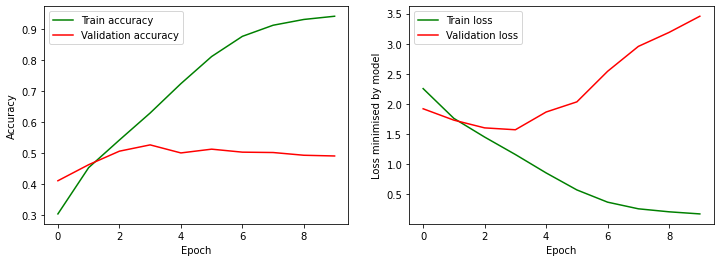

In [44]:
# model_1 now contains the model at the end of the training run
# We analyse the result:

[train_loss, train_accuracy] = model_1.evaluate(X_train, y_train, verbose=0)
print("Training set Accuracy:{:7.2f}".format(train_accuracy))
print("Training set Loss:{:7.4f}\n".format(train_loss))

[val_loss, val_accuracy] = model_1.evaluate(X_val, y_val, verbose=0)
print("Validation set Accuracy:{:7.2f}".format(val_accuracy))
print("Validation set Loss:{:7.4f}\n".format(val_loss))

#Now we visualise what happened during training
plot_history(history_1)

## Final model and analysis

Once you are happy with how your model performs on the validation set, it is time to re-train it on the original training set (i.e., including the validation set). This means that you no longer have a validation set to use during training. So you only have to execute the following steps once you are satisfied with the model you created!

Once this re-training has been done, you can analyse how your network performs on the test set.



In [ ]:
model_for_test = initial_model()
model_for_test.summary()

# We now add batch size to the mix of training parameters
# If you don't specify batch size below, all training data will be used for each learning step
batch_size = 128
epochs = 50

history_for_test = model_for_test.fit(X_train_all, y_train_all,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1
                    )



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
469/469 [==============================] - 1s 2ms/step - loss: 0.4159 - accuracy: 0.8813
Epoch 2/50
469/469 [==============================] - 1s 2ms/step - loss: 0.1680 - accuracy: 0.9509
Epoch 3/50
469/469 [==============================] - 1s 2ms/step - loss: 0.1236 - accuracy: 0.9634
Epoch 4/50
469/469 [==============================] - 1s 2ms/step - loss: 0.0971

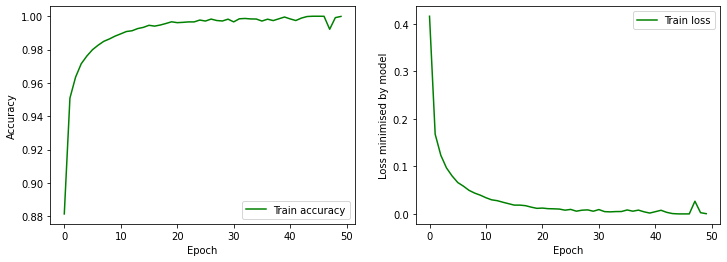

In [ ]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history_for_test.epoch, np.array(history_for_test.history['accuracy']),'g-',
        label='Train accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Loss minimised by model')
plt.plot(history_for_test.epoch, np.array(history_for_test.history['loss']),'g-',
        label='Train loss')
plt.legend()

Finally we calculate the predictive accuracy of the model. 

In [ ]:
[train_loss, train_accuracy] = model_for_test.evaluate(X_train_all, y_train_all, verbose=0)
print("Training set Accuracy:{:7.2f}".format(train_accuracy))
print("Training set Loss:{:7.4f}\n".format(train_loss))

[test_loss, test_accuracy] = model_for_test.evaluate(X_test, y_test, verbose=0)
print("Test set Accuracy:{:7.2f}".format(test_accuracy))
print("Test set Loss:{:7.4f}\n".format(test_loss))



Training set Accuracy:   1.00
Training set Loss: 0.0007

Test set Accuracy:   0.98
Test set Loss: 0.1366



## Evaluation

Finally, we visualize some incorrectly predicted digits.

In [ ]:
predictions = model_for_test.predict(X_test)
# The first digit should be a 7 (shown as 1. at index 7)
print(y_test[0])

# Check the probabilities returned by predict for first test sample
# The function enumerate() receives and iterable and creates an iterator that, for each element, 
# returns a tuple containing the element's index and value
for index, probability in enumerate(predictions[0]):
    print(f'{index}: {probability:.10%}')
    
# Our model believes this digit is a 7 with nearly 100% certainty
# Not all predictions have this level of certainty

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
0: 0.0000000000%
1: 0.0000000000%
2: 0.0000000000%
3: 0.0000000000%
4: 0.0000000000%
5: 0.0000000000%
6: 0.0000000000%
7: 100.0000000000%
8: 0.0000000000%
9: 0.0000000000%


In the following snippet, p is the predicted value array, and e is the expected value array
NumPy’s argmax() function determines then index of an array’s highest valued element
Python's built-in zip function enables you to iterate over multiple iterables of data at the same time. The function receives as arguments any number of iterables and returns an iterator that produces tuples containing the elements at the same index in each.

In [ ]:
# Locating the Incorrect Predictions
images = X_test.reshape((10000, 28, 28))

incorrect_predicted_images = []
predicted_digits = []
expected_digits = []

for i, (p, e) in enumerate(zip(predictions, y_test)):
    predicted, expected = np.argmax(p), np.argmax(e)

    if predicted != expected:  # prediction was incorrect
        incorrect_predicted_images.append(images[i])
        predicted_digits.append(predicted)
        expected_digits.append(expected)

<Figure size 432x288 with 0 Axes>

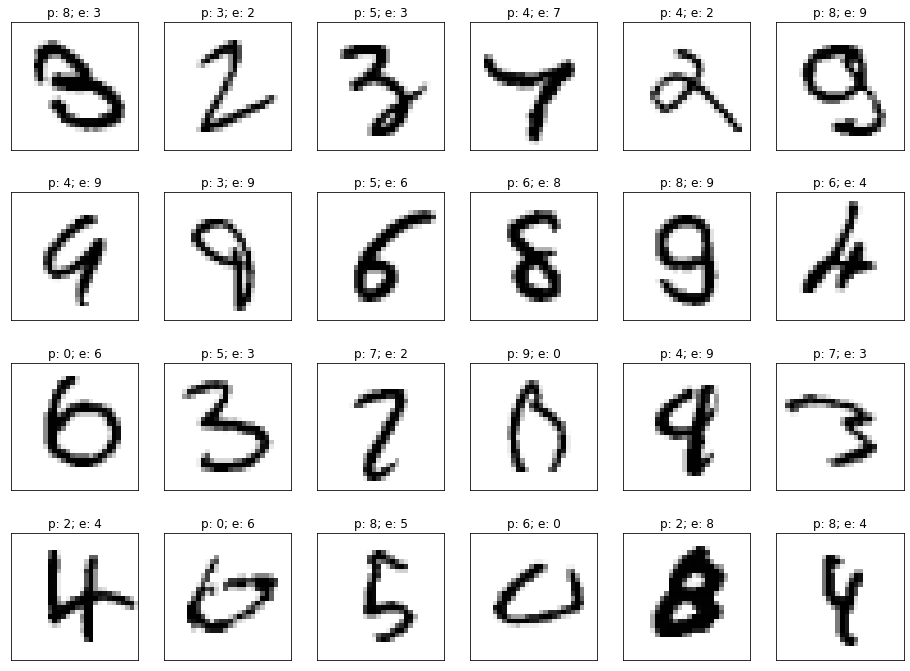

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.figure()
nrows,ncols=4,6
plt.subplots(nrows,ncols, figsize=(16, 12))

for i in range(nrows*ncols):  # show first 24 digits
  plt.subplot(nrows,ncols,i+1)  # i+1 is position of subplot in nrows x ncols table
  # show bitmap, interpret 0 as white and 255 as black (grayvalues)
  plt.imshow(incorrect_predicted_images[i].reshape(28,28), cmap=plt.cm.gray_r)
  plt.title(f'p: {predicted_digits[i]}; e: {expected_digits[i]}')
  plt.xticks([])   # no ticks on x axis
  plt.yticks([])   # not ticks on y axis